# Support Vector Machine (SVM) 

To support the lecture 12 in Statistical Inference and Modeling 2102575 by *Suwichaya Suwanwimolkul, Ph.D.*

- [Data preprocessing](#data-preprocessing)
- [Training data distribution](#training-data-distribution)
- [Train SVM using different kernels: linear, poly, rbf](#training-the-svm-model-using-linear-poly-rbf)
- [Validating SVM using different kernels: linear, poly, rbf](#validating-performance-of-different-kernels) 

## Data preprocessing

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics  
import seaborn as sns

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed) 
    perm         = np.random.permutation(df.index)
    m            = len(df.index) 
    train_end    = int(np.floor(int(train_percent * m)))
    validate_end = int(np.floor(int(validate_percent * m) + train_end)) 
    
    train        = df.iloc[perm[:train_end]]
    validate     = df.iloc[perm[train_end:validate_end]]
    test         = df.iloc[perm[validate_end:]] 
 

    train       = train.reset_index(drop=True)
    validate    = validate.reset_index(drop=True)
    test        = test.reset_index(drop=True)
    
    return train, validate, test

In [2]:
foldername = "iris" 
df_loaded = pd.read_csv('%s/iris_synthetic_data.csv' % foldername)   
df_loaded.keys()

label_string = np.unique(df_loaded['label'].values).tolist() 
binary_label = [label_string[1], label_string[2]]


df_1 = df_loaded.loc[df_loaded['label'] == binary_label[0]]
df_2 = df_loaded.loc[df_loaded['label'] == binary_label[1]]

df   = pd.concat([df_1, df_2], ignore_index=True) 

target_column = ['label']
feat_column   = ['sepal length', 'petal width'] # 'sepal length', 'sepal width', 'petal length', 'petal width'

all_column =  target_column + feat_column
df = df[all_column]
df = df.apply(LabelEncoder().fit_transform)

train_df,  valid_df, test_df = train_validate_test_split(df, train_percent=.8, validate_percent=.1, seed=None)

X_scaler = StandardScaler() 
train_df[feat_column].values[:]        = X_scaler.fit_transform(train_df[feat_column].values[:] )
valid_df[feat_column].values[:]        = X_scaler.transform(valid_df[feat_column].values[:] )
test_df[feat_column].values[:]         = X_scaler.transform(test_df[feat_column].values[:] )


all_column = target_column + feat_column
train_enc = train_df[all_column]

print("# Training   dataset: %d" % len(train_df))
print("# Validating dataset: %d" % len(valid_df))
print("# Testing    dataset: %d" % len(test_df))

# Training   dataset: 1600
# Validating dataset: 200
# Testing    dataset: 200


## Training data distribution

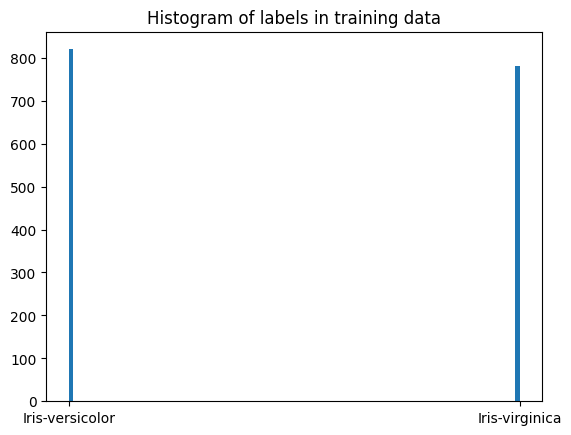

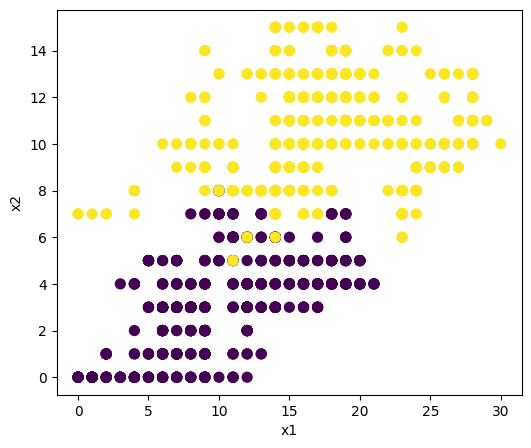

In [3]:
train_enc_array = train_enc[target_column].values
 
plt.hist(train_enc_array, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of labels in training data")
plt.xticks(np.unique(train_enc[target_column].values).tolist(), binary_label,  rotation=0)
plt.show()

x1 = train_enc[feat_column[0]].values
x2 = train_enc[feat_column[1]].values
y  = train_enc[target_column].values

plt.figure(figsize=(6, 5))   
plt.scatter(x1, x2, c=y, s=50 )
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Training the SVM model using linear, poly, rbf

In [4]:
from sklearn import svm

X_train = train_enc[feat_column].values
y_train = train_enc[target_column].values

clf_linear = svm.SVC(kernel='linear')  
clf_linear.fit(X_train, y_train)

clf_poly = svm.SVC(kernel='poly')  
clf_poly.fit(X_train, y_train) 

clf_rbf = svm.SVC(kernel='rbf')  
clf_rbf.fit(X_train, y_train)

/home/gabby/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/gabby/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/gabby/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

### Check how the model is shaped by the training data

In [5]:
def plotting_decision_contour(clf, X_train):
    h = 0.02  # step size in the mesh
    x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    Z = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])  
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, cmap=plt.cm.Pastel2)


def show_trained_model_behavior(clf_list, clf_namelist, X_train, y_train):
    figsize=(15, 5)
    plt.figure(figsize=figsize)
    for index, (clf, name) in enumerate(zip(clf_list, clf_namelist)):
        plt.subplot(1, len(clf_list), index+1)

        plotting_decision_contour(clf, X_train) 

        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, alpha=0.95, edgecolors='k') 
        plt.ylabel("x2")
        plt.xlabel("x1")
        plt.title("SVM with %s kernel" % name)

    plt.tight_layout()
    plt.savefig("trained_%s.png" % "-".join(clf_namelist))  
    plt.show()


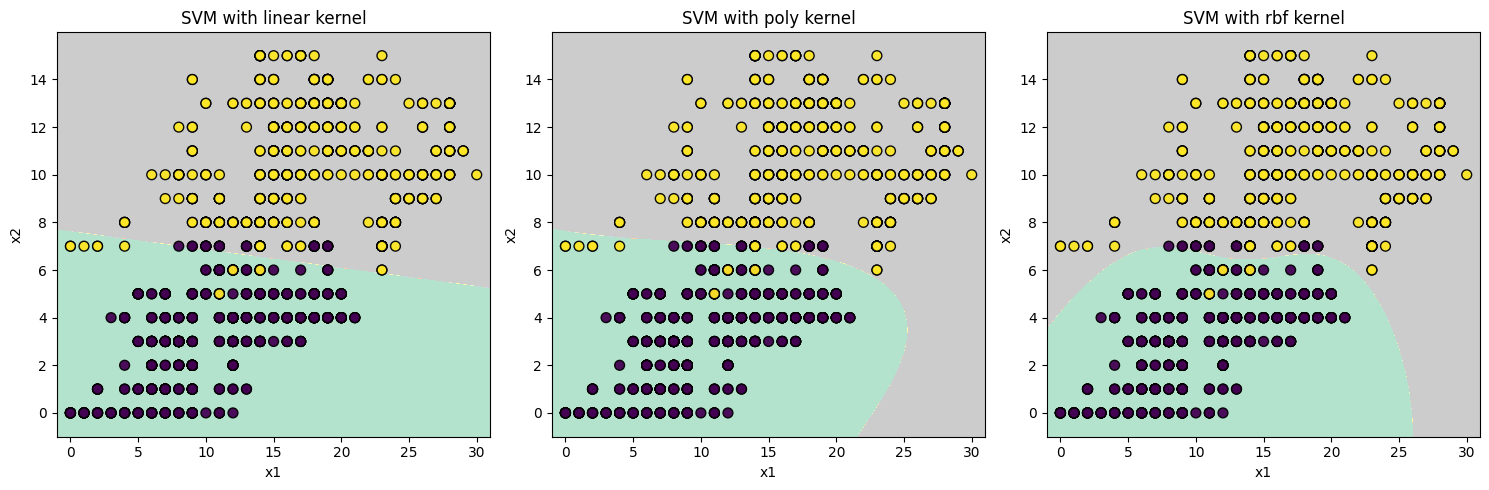

In [6]:
clf_list = [clf_linear, clf_poly, clf_rbf]
clf_name_list = ['linear', 'poly', 'rbf']
show_trained_model_behavior(clf_list, clf_name_list, X_train, y_train)


## Validating performance of different kernels

In the following, we use the learned model to predict the label by running

`y_pred = clf.predict(X_test) `

Then, we calculate the confusion matrix to evaluate the model performance.

`confusion_matrix(y_test, y_pred)`

Finally, we visualize the testing data samples compared to the decision boundary of the trained model. 

In [7]:
from sklearn.metrics import confusion_matrix

X_valid = valid_df[feat_column].values
y_valid = valid_df[target_column].values.reshape(-1) 


clf_list = [clf_linear, clf_poly, clf_rbf]
clf_name_list = ['linear', 'poly', 'rbf']

for clf, name in zip(clf_list, clf_name_list):
    y_pred = clf.predict(X_valid)  
    print("Confusion Matrix for %s kernel:" % name)
    print(confusion_matrix(y_valid, y_pred))
    print()
 

Confusion Matrix for linear kernel:
[[ 79   3]
 [  3 115]]

Confusion Matrix for poly kernel:
[[ 80   2]
 [  4 114]]

Confusion Matrix for rbf kernel:
[[ 79   3]
 [  2 116]]



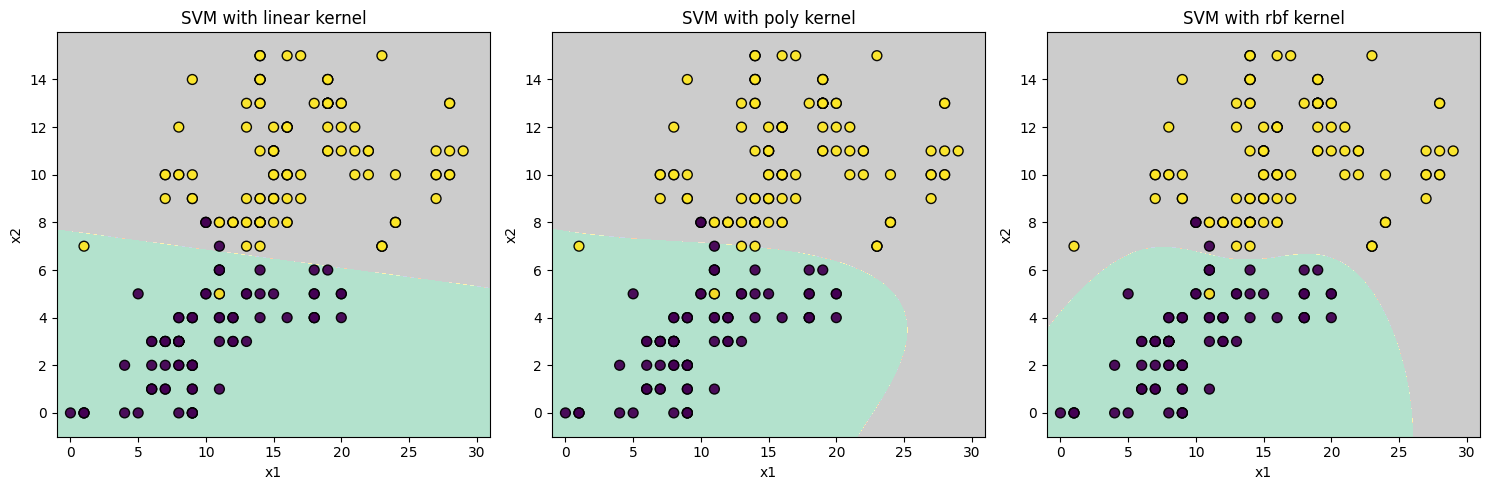

In [8]:
def show_valid_performance(clf_list, clf_namelist, X_test, y_test, X_train):
    figsize=(15, 5)
    plt.figure(figsize=figsize)
    for index, (clf, name) in enumerate(zip(clf_list, clf_namelist)): 
        plt.subplot(1, len(clf_list), index+1)

        plotting_decision_contour(clf, X_train) 

        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, alpha=0.95, edgecolors='k') 
        plt.ylabel("x2")
        plt.xlabel("x1")
        plt.title("SVM with %s kernel" % name) 

    plt.tight_layout()
    plt.savefig("valid_%s.png" % "-".join(clf_namelist))  
    plt.show()


show_valid_performance(clf_list, clf_name_list, X_valid, y_valid, X_train)
